In [549]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [558]:
# Reading through the IMDB data to see what peoples feelings were towards movies
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']

In [559]:
# Building my keyword list

keywords = ['and',
            'even',
            'good',
            'plot',
            'enjoy',
            'best', #not very strong
            'love',
            'cool', #also pretty weak
            'awesome',
            'film',
            'for',
            'is',
            'was',
            'i',
            'not',
            'a',
            'to',
            'just',
            'know',
            'wonderful',
            'only',
            'great',
            'bad.',
            'waste',
            'like',
            'really',
            'excellent',
           ]
for key in keywords:
    data[str(key)] = data.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

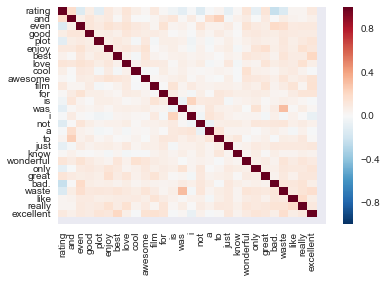

In [560]:
# Pretty light correlation outside of 'was' and 'waste' from from the sentence 'this 
# movie was a waste of time'
sns.heatmap(data.corr())

trainer = data[keywords]
target = data['rating']

In [561]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(trainer, target)

y_pred = bnb.predict(trainer)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer.shape[0],
    (target != y_pred).sum()
))

Number of incorrectly predicted ratings out of a total 748 reviews : 208


In [556]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[258, 104],
       [104, 282]])

Everything below here is reworking the data to get at some of the most popular words.

In [555]:
# building separate dataframes from the positive and negative reviews
pos_data = data[data['rating'] == 1]['message'].reset_index(drop = True)
neg_data = data[data['rating'] == 0]['message'].reset_index(drop = True)

In [92]:
#building dictionaries to find the most common words for each review type
pos_dict = {}
neg_dict = {}
for i in pos_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in pos_dict:
            pos_dict[word] = 1
        else:
            pos_dict[word] += 1            

for i in neg_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in neg_dict:
            neg_dict[word] = 1
        else:
            neg_dict[word] += 1
            

In [95]:
import operator
sorted_pos_dict = sorted(pos_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_neg_dict = sorted(neg_dict.items(), key=operator.itemgetter(1), reverse = True)

In [96]:
sorted_pos_dict[:50]

[('', 842),
 ('the', 388),
 ('and', 249),
 ('a', 227),
 ('of', 184),
 ('is', 145),
 ('i', 132),
 ('this', 130),
 ('to', 111),
 ('in', 107),
 ('it', 84),
 ('was', 72),
 ('that', 65),
 ('movie', 64),
 ('film', 59),
 ('with', 48),
 ('as', 47),
 ('for', 43),
 ('but', 40),
 ('are', 38),
 ('you', 33),
 ('good', 31),
 ("it's", 30),
 ('on', 30),
 ('one', 30),
 ('very', 27),
 ('an', 26),
 ('so', 25),
 ('at', 24),
 ('great', 24),
 ('has', 24),
 ('like', 23),
 ('from', 23),
 ('really', 23),
 ('by', 22),
 ('his', 21),
 ('not', 21),
 ('have', 20),
 ('it.', 20),
 ('if', 20),
 ('see', 20),
 ('about', 19),
 ('be', 19),
 ('all', 19),
 ('more', 19),
 ('just', 19),
 ('out', 18),
 ('were', 18),
 ('who', 18),
 ('my', 17)]

In [97]:
sorted_neg_dict[:50]

[('', 910),
 ('the', 407),
 ('a', 200),
 ('of', 189),
 ('is', 180),
 ('and', 170),
 ('this', 138),
 ('to', 136),
 ('i', 108),
 ('was', 107),
 ('it', 97),
 ('in', 91),
 ('that', 83),
 ('movie', 69),
 ('for', 59),
 ('not', 51),
 ('film', 48),
 ('as', 46),
 ('just', 44),
 ('but', 42),
 ('with', 41),
 ('on', 38),
 ('bad', 38),
 ('are', 37),
 ('one', 37),
 ('you', 36),
 ('very', 33),
 ('so', 31),
 ('be', 31),
 ('all', 31),
 ('even', 31),
 ('about', 29),
 ('there', 27),
 ('at', 26),
 ('have', 26),
 ("it's", 26),
 ('an', 26),
 ('no', 24),
 ('how', 24),
 ('like', 24),
 ('by', 24),
 ('or', 24),
 ('from', 23),
 ('only', 22),
 ('\t0\nthe', 22),
 ('-', 21),
 ('most', 20),
 ('were', 19),
 ('he', 18),
 ('plot', 18)]

In [106]:
df_pos = pd.DataFrame(sorted_pos_dict)
df_pos.columns = ['word', 'count']
df_neg = pd.DataFrame(sorted_neg_dict)
df_neg.columns = ['word', 'count']

In [107]:
print(df_pos.head())
print('-'*30)
print(df_neg.head())

  word  count
0         842
1  the    388
2  and    249
3    a    227
4   of    184
------------------------------
  word  count
0         910
1  the    407
2    a    200
3   of    189
4   is    180


In [114]:
posneg_df = pd.merge(df_pos, df_neg, on='word', how='outer')
posneg_df.columns = ['word', 'positive', 'negative']
posneg_df['difference'] = abs((posneg_df.positive - posneg_df.negative))

In [116]:
posneg_df.head(50)

,word,positive,negative,difference
0,,842.0,910.0,68.0
1,the,388.0,407.0,19.0
2,and,249.0,170.0,79.0
3,a,227.0,200.0,27.0
4,of,184.0,189.0,5.0
5,is,145.0,180.0,35.0
6,i,132.0,108.0,24.0
7,this,130.0,138.0,8.0
8,to,111.0,136.0,25.0
9,in,107.0,91.0,16.0


In [557]:
# I used a lot of the words high on this list figuring the larger the difference in usage
# the more effect it would have on the predictive value of the model
posneg_df.sort_values(by = 'difference', ascending = False)

,word,positive,negative,difference
2,and,249.0,170.0,79.0
0,,842.0,910.0,68.0
5,is,145.0,180.0,35.0
11,was,72.0,107.0,35.0
187,bad,5.0,38.0,33.0
36,not,21.0,51.0,30.0
3,a,227.0,200.0,27.0
8,to,111.0,136.0,25.0
45,just,19.0,44.0,25.0
6,i,132.0,108.0,24.0
